# Регрессионный анализатор для оценки доменов 

In [1]:
!nvidia-smi

Sun Mar 24 19:33:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti     On  | 00000000:01:00.0  On |                  N/A |
| 84%   35C    P8              23W / 331W |   1624MiB /  8192MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install pycaret
!pip install mlflow
%pip install scipy==1.11.4

from pycaret.classification import *

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.8 MB/s eta 0:00:00-:--:--
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.4 MB/s eta 0:00:00


In [3]:
df = pd.read_csv('./work/datasets/processed_actual/merged_full_2024_03_24.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183479 entries, 0 to 183478
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   domain            183479 non-null  object 
 1   tld               183479 non-null  object 
 2   levels_count      183479 non-null  int64  
 3   levels_mad        183479 non-null  float64
 4   symbols_count     183479 non-null  int64  
 5   vowels_ratio      183479 non-null  float64
 6   consonants_ratio  183479 non-null  float64
 7   numbers_ratio     183479 non-null  float64
 8   points_ratio      183479 non-null  float64
 9   special_ratio     183479 non-null  float64
 10  unique_ratio      183479 non-null  float64
 11  max_repeated      183479 non-null  int64  
 12  a_records         183479 non-null  int64  
 13  mx_records        183479 non-null  int64  
 14  cname_records     183479 non-null  int64  
 15  txt_records       183479 non-null  int64  
 16  ptr_records       18

## Визуализация и анализ собранных данных

In [51]:
plt.style.use('fivethirtyeight')

<Figure size 640x480 with 0 Axes>

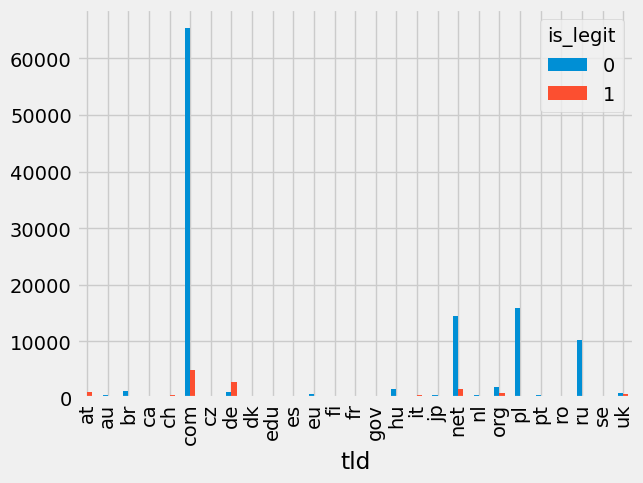

In [53]:
count_by_tld = df.groupby(['tld', 'is_legit']).size().unstack(level=1)
count_by_tld = count_by_tld[count_by_tld[1] > 100]

count_by_tld.plot(kind='bar')
plt.savefig('savefig_tld.png')

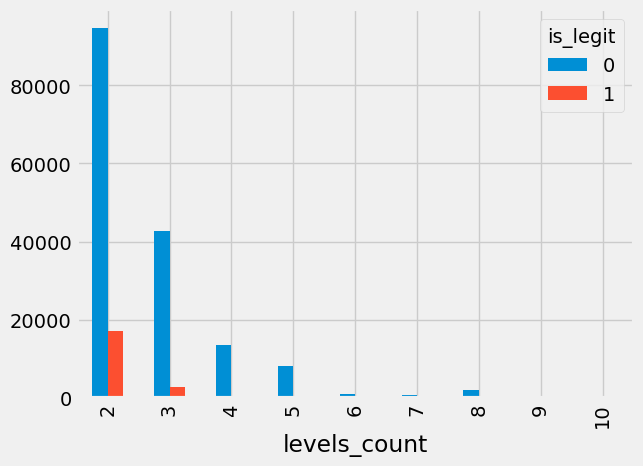

In [84]:
count_by_levels = df.groupby(['levels_count', 'is_legit']).size().unstack(level=1)
count_by_levels = count_by_levels[count_by_levels[0] > 5]

count_by_levels.plot(kind='bar')
plt.savefig('savefig_levels.png')

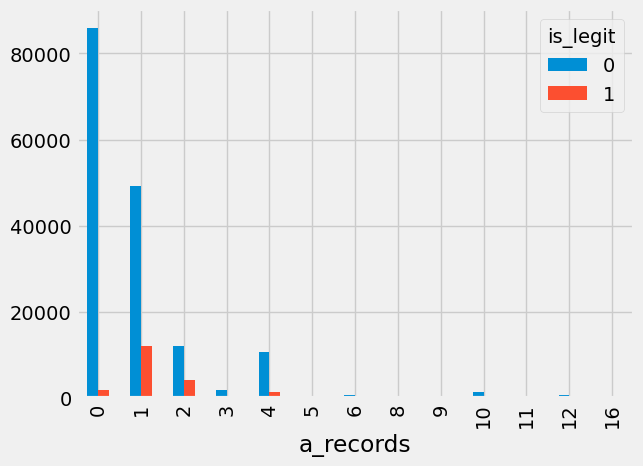

In [94]:
count_by_a_records = df.groupby(['a_records', 'is_legit']).size().unstack(level=1)
count_by_a_records = count_by_a_records[count_by_a_records[1] > 1]

count_by_a_records.plot(kind='bar')
plt.savefig('savefig_a_records.png')

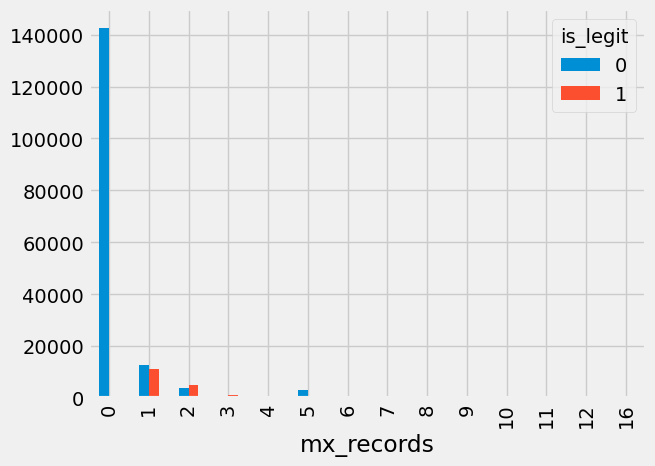

In [99]:
count_by_mx_records = df.groupby(['mx_records', 'is_legit']).size().unstack(level=1)
count_by_mx_records = count_by_mx_records[count_by_mx_records[1] > 1]

count_by_mx_records.plot(kind='bar')
plt.savefig('savefig_mx_records.png')

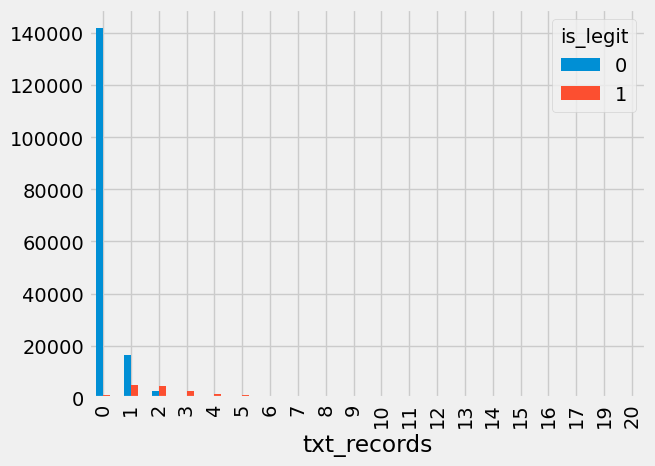

In [113]:
count_by_txt_records = df.groupby(['txt_records', 'is_legit']).size().unstack(level=1)
count_by_txt_records = count_by_txt_records[count_by_txt_records[0] > 5]

count_by_txt_records.plot(kind='bar')
plt.savefig('savefig_txt_records.png')

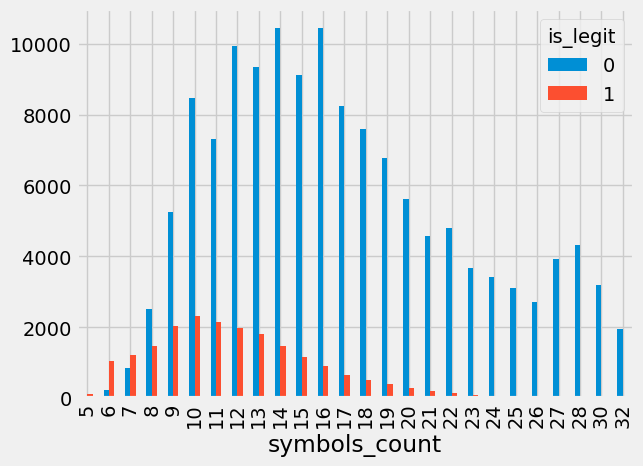

In [100]:
count_by_length_records = df.groupby(['symbols_count', 'is_legit']).size().unstack(level=1)
count_by_length_records = count_by_length_records[count_by_length_records[1] > 1]

count_by_length_records.plot(kind='bar')
plt.savefig('savefig_length_records.png')

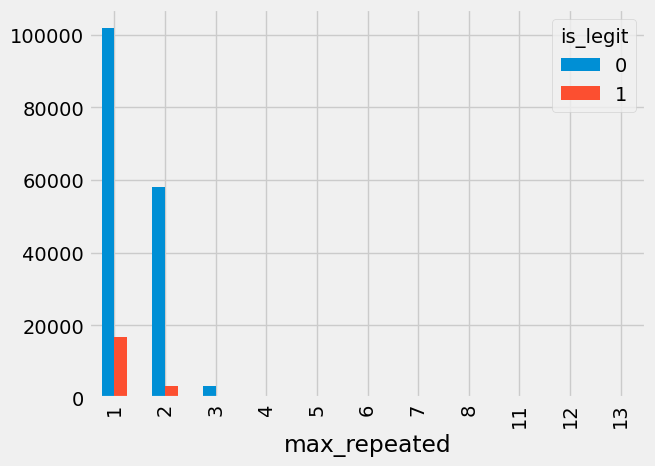

In [105]:
count_by_repeated_records = df.groupby(['max_repeated', 'is_legit']).size().unstack(level=1)
# count_by_repeated_records = count_by_repeated_records[count_by_repeated_records[1] > 1]

count_by_repeated_records.plot(kind='bar')
plt.savefig('savefig_repeated_records.png')

## Семантический анализ

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183479 entries, 0 to 183478
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   domain            183479 non-null  object 
 1   tld               183479 non-null  object 
 2   levels_count      183479 non-null  int64  
 3   levels_mad        183479 non-null  float64
 4   symbols_count     183479 non-null  int64  
 5   vowels_ratio      183479 non-null  float64
 6   consonants_ratio  183479 non-null  float64
 7   numbers_ratio     183479 non-null  float64
 8   points_ratio      183479 non-null  float64
 9   special_ratio     183479 non-null  float64
 10  unique_ratio      183479 non-null  float64
 11  max_repeated      183479 non-null  int64  
 12  a_records         183479 non-null  int64  
 13  mx_records        183479 non-null  int64  
 14  cname_records     183479 non-null  int64  
 15  txt_records       183479 non-null  int64  
 16  ptr_records       18

In [4]:
df = pd.read_csv('./work/datasets/processed_actual/merged_full_2024_03_24.csv')

df_semantic = df[
    ["domain", "levels_count", "levels_mad", "symbols_count", "vowels_ratio", "consonants_ratio", "numbers_ratio",
     "points_ratio", "special_ratio", "unique_ratio", "max_repeated", "is_legit"]]

df_semantic = df_semantic.astype({'domain': 'string'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183479 entries, 0 to 183478
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   domain            183479 non-null  string 
 1   levels_count      183479 non-null  int64  
 2   levels_mad        183479 non-null  float64
 3   symbols_count     183479 non-null  int64  
 4   vowels_ratio      183479 non-null  float64
 5   consonants_ratio  183479 non-null  float64
 6   numbers_ratio     183479 non-null  float64
 7   points_ratio      183479 non-null  float64
 8   special_ratio     183479 non-null  float64
 9   unique_ratio      183479 non-null  float64
 10  max_repeated      183479 non-null  int64  
 11  is_legit          183479 non-null  int64  
dtypes: float64(7), int64(4), string(1)
memory usage: 16.8 MB


In [5]:
semantic_setup = setup(df_semantic, target='is_legit', session_id=123, use_gpu=True, log_experiment=True,
             experiment_name='semantic_classification')

best_model = compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,123
1,Target,is_legit
2,Target type,Binary
3,Original data shape,"(183479, 12)"
4,Transformed data shape,"(183479, 12)"
5,Transformed train set shape,"(128435, 12)"
6,Transformed test set shape,"(55044, 12)"
7,Numeric features,10
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
2024/03/24 16:34:20 INFO mlflow.tracking.fluent: Experiment with name 'semantic_classification' does not exist. Creating a new experiment.


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:34:20
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:34:20
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


KeyboardInterrupt: 

In [ ]:
# df = df.drop(columns=df.columns[], axis=1)